# Deal or No Deal

## Technical Analysis Based LSTM Pricing Model

### Dependency

In [285]:
import os
import glob
import random
from pathlib import Path
from datetime import datetime
from enum import Enum

import matplotlib
%matplotlib inline

import collections
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

from torch import nn
import torch.tensor
import torch.optim as optim
import torch.nn.functional as F

from talib import RSI, BBANDS, ADOSC

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.mode.chained_assignment = None

### Configs

In [286]:
DATE_BEGIN = datetime.strptime('1998-01-01', '%Y-%m-%d')

TRAINING_DATE_TO = datetime.strptime('2019-06-30', '%Y-%m-%d')

VALIDATION_DATE_FROM = datetime.strptime('2019-07-01', '%Y-%m-%d')
VALIDATION_DATE_TO = datetime.strptime('2019-12-31', '%Y-%m-%d')

TESTING_DATE_FROM = datetime.strptime('2020-01-01', '%Y-%m-%d')
TESTING_DATE_TO = datetime.strptime('2020-02-13', '%Y-%m-%d')

In [287]:
DATA_DIR = '..'
REGION = 'us'
INSTRUMENT = 'unh'

RAW_DATA_FULL_FEATURES_SET = ['date', 'open', 'high', 'low', 'close', 'volume', 'openint']
RAW_DATA_REMOVED_FEATURES_SET = ['open', 'high', 'low', 'close']
RAW_DATA_ADDED_FEATURES_SET = ['volume']
RAW_DATA_FEATURES_SET = RAW_DATA_REMOVED_FEATURES_SET + RAW_DATA_ADDED_FEATURES_SET

RAW_DATA_FEATURES_SET = ['open', 'high', 'low', 'close', 'volume']
RAW_TARGET = 'close'

FEATURES_SET = ['open',
                'high',
                'low',
                'close',
                'volume',
#                 'ta_bbands_up',
#                 'ta_bbands_mid',
#                 'ta_bbands_low',
#                 'ta_osc_ad'
               ]
TARGET = 'close_delta'

EXECLUDE_FIELDS = ['date', 'openint', 'close_t1']

## Helpers

### Market Data

In [288]:
def fetch_instrument_file(instrument, region, base_dir):
    cwd = os.getcwd()
    os.chdir(base_dir)
    
    instrument_file_list = result = list(Path('.').rglob(f"*{instrument}*.txt"))
    if not instrument_file_list:
        os.chdir(cwd)
        raise Exception(f'Cannot find file for instrument {instrument}')
    if len(instrument_file_list) > 1:
        os.chdir(cwd)
        raise Exception(f'Found multiple file for instrument {instrument}')
        
    os.chdir(cwd)
    return str(os.path.normpath(
                    os.path.join(os.getcwd(), base_dir, instrument_file_list[0])
                )
            )

instrument_data_file = fetch_instrument_file(INSTRUMENT, REGION, DATA_DIR)
instrument_data_file

'c:\\data\\deal-nodeal\\data\\daily\\us\\nyse stocks\\2\\unh.us.txt'

# Data Preparation 

In [289]:
instrument_data_file = fetch_instrument_file(INSTRUMENT, REGION, DATA_DIR)
instrument_data_file

'c:\\data\\deal-nodeal\\data\\daily\\us\\nyse stocks\\2\\unh.us.txt'

In [290]:
df = pd.read_csv(instrument_data_file)
df.columns = RAW_DATA_FULL_FEATURES_SET

df.date = pd.to_datetime(df.date, format='%Y%m%d')
df['volume'] = df['volume'].astype('float64')
df

,date,open,high,low,close,volume,openint
0,1990-03-26,0.25264,0.25264,0.25264,0.25264,473990.0,0
1,1990-03-27,0.25264,0.26996,0.25264,0.26996,4493732.0,0
2,1990-03-28,0.26996,0.26996,0.26119,0.26119,1793083.0,0
3,1990-03-29,0.26996,0.26996,0.26119,0.26119,617291.0,0
4,1990-03-30,0.26996,0.26996,0.26119,0.26119,2017221.0,0
...,...,...,...,...,...,...,...
7510,2020-01-16,298.00000,300.99000,295.93000,300.74000,3710344.0,0
7511,2020-01-17,300.01000,300.70000,295.88000,298.47000,4632160.0,0
7512,2020-01-21,296.89000,302.54000,296.01000,300.53000,4963132.0,0
7513,2020-01-22,301.99000,302.13000,297.35000,300.59000,3117568.0,0


#### Split/Revers dataset - (Training / Validation / Testing)

In [291]:
training_df = df[(df['date'] >= DATE_BEGIN) & (df['date'] <= TRAINING_DATE_TO)] 
training_df = training_df.reset_index()
training_df.drop(['index'], axis=1, inplace=True)
training_df = training_df[::-1]
training_df

validation_df = df[(df['date'] >= DATE_BEGIN) & (df['date'] <= VALIDATION_DATE_TO)] 
validation_df = validation_df.reset_index()
validation_df.drop(['index'], axis=1, inplace=True)
validation_df = validation_df[::-1]
validation_df

testing_df = df[(df['date'] >= DATE_BEGIN) & (df['date'] <= TESTING_DATE_TO)] 
testing_df = testing_df.reset_index()
testing_df.drop(['index'], axis=1, inplace=True)
testing_df = testing_df[::-1]
testing_df

,date,open,high,low,close,volume,openint
5405,2019-06-28,244.4000,244.6500,236.6200,241.9300,6785360.0,0
5404,2019-06-27,242.1800,246.0400,241.0900,244.2400,3395049.0,0
5403,2019-06-26,245.8900,245.9700,241.0600,241.4000,3885971.0,0
5402,2019-06-25,247.1800,248.9000,245.3200,245.5600,3210315.0,0
5401,2019-06-24,249.1900,250.4800,245.7600,247.5200,3190897.0,0
...,...,...,...,...,...,...,...
4,1998-01-08,5.4694,5.5389,5.4520,5.4865,10518759.0,0
3,1998-01-07,5.4081,5.4865,5.3734,5.4694,9828902.0,0
2,1998-01-06,5.3302,5.4344,5.2604,5.4172,8710979.0,0
1,1998-01-05,5.3995,5.4694,5.3822,5.3911,7450674.0,0


,date,open,high,low,close,volume,openint
5533,2019-12-31,293.6600,294.0900,291.1500,293.9800,2224237.0,0
5532,2019-12-30,296.0500,296.5400,293.4500,293.8500,1512088.0,0
5531,2019-12-27,296.0100,296.5400,295.0140,295.9700,1547211.0,0
5530,2019-12-26,295.3000,296.2600,294.5400,295.6500,1050688.0,0
5529,2019-12-24,295.2600,295.8300,293.5600,294.5400,714032.0,0
...,...,...,...,...,...,...,...
4,1998-01-08,5.4694,5.5389,5.4520,5.4865,10518759.0,0
3,1998-01-07,5.4081,5.4865,5.3734,5.4694,9828902.0,0
2,1998-01-06,5.3302,5.4344,5.2604,5.4172,8710979.0,0
1,1998-01-05,5.3995,5.4694,5.3822,5.3911,7450674.0,0


,date,open,high,low,close,volume,openint
5548,2020-01-23,300.0100,300.5800,296.6500,299.4600,3169442.0,0
5547,2020-01-22,301.9900,302.1300,297.3500,300.5900,3117568.0,0
5546,2020-01-21,296.8900,302.5400,296.0100,300.5300,4963132.0,0
5545,2020-01-17,300.0100,300.7000,295.8800,298.4700,4632160.0,0
5544,2020-01-16,298.0000,300.9900,295.9300,300.7400,3710344.0,0
...,...,...,...,...,...,...,...
4,1998-01-08,5.4694,5.5389,5.4520,5.4865,10518759.0,0
3,1998-01-07,5.4081,5.4865,5.3734,5.4694,9828902.0,0
2,1998-01-06,5.3302,5.4344,5.2604,5.4172,8710979.0,0
1,1998-01-05,5.3995,5.4694,5.3822,5.3911,7450674.0,0


In [292]:
scaler = StandardScaler()

class features_extraction_ops(Enum):
    calc_features_X = 'calc_features_X'
    calc_target_y = 'calc_target_y'
    
    clean = 'clean'
    
    statistics = 'statistics'
    
    normalize_train = 'normalize_train'
    normalize_validation = 'normalize_validation'
    normalize_test = 'normalize_test'
    
    profile = 'profile'

def features_extraction(df, ops = []):
    def _calc_feature_X(df):
        target_field_values = df[RAW_TARGET].values
        df['ta_bbands_up'], df['ta_bbands_mid'], df['ta_bbands_low'] = BBANDS(target_field_values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        
        high = df['high'].values
        low = df['low'].values
        close = df['close'].values
        volume = df['volume'].values
        df['ta_osc_ad'] = ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
        return df
    
    def _calc_target_y(df):
        df[f'{RAW_TARGET}_t1'] = df[RAW_TARGET].shift(-1)
        df[f'{RAW_TARGET}_delta'] = df[f'{RAW_TARGET}_t1'] - df[RAW_TARGET]
        return df
    
    def _clean(df):
        df.dropna(inplace=True)
        return df

    def _statistics(df):
        return df.describe()
    
    def _normalize_train(df):
        for feature in df.columns:
            if feature == 'date':
                continue
                LR = LogisticRegression(C=0.01, solver='liblinear').fit(normalized_x_train, y_train)
            df[feature] = scaler.fit_transform(df[[feature]])
        return df
    
    def _normalize_validation(df):
        for feature in df.columns:
            if feature == 'date':
                continue    
            df[feature] = scaler.transform(df[[feature]])        
        return df
    
    def _normalize_test(df):
        for feature in df.columns:
            if feature == 'date':
                continue    
            df[feature] = scaler.transform(df[[feature]])        
        return df
    
    def _profile(df):
        return ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})

    if features_extraction_ops.calc_features_X in ops:
        df = _calc_feature_X(df)
    elif features_extraction_ops.calc_target_y in ops:
        df = _calc_target_y(df)
    elif features_extraction_ops.clean in ops:
        df = _clean(df)
    elif features_extraction_ops.statistics in ops:
        df = _statistics(df)
    elif features_extraction_ops.normalize_train in ops:
        df = _normalize_train(df)
    elif features_extraction_ops.normalize_validation in ops:
        df = _normalize_validation(df)
    elif features_extraction_ops.normalize_test in ops:
        df = _normalize_test(df)
    elif features_extraction_ops.profile in ops:
        return _profile(df)
        
    return df


# Data Preparation /Testings


In [293]:
training_df = features_extraction(training_df, [features_extraction_ops.calc_features_X])
training_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad
5405,2019-06-28,244.4000,244.6500,236.6200,241.9300,6785360.0,0,NaN,NaN,NaN,NaN
5404,2019-06-27,242.1800,246.0400,241.0900,244.2400,3395049.0,0,NaN,NaN,NaN,NaN
5403,2019-06-26,245.8900,245.9700,241.0600,241.4000,3885971.0,0,NaN,NaN,NaN,NaN
5402,2019-06-25,247.1800,248.9000,245.3200,245.5600,3210315.0,0,NaN,NaN,NaN,NaN
5401,2019-06-24,249.1900,250.4800,245.7600,247.5200,3190897.0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4,1998-01-08,5.4694,5.5389,5.4520,5.4865,10518759.0,0,5.748677,5.350765,4.952853,-1.057607e+07
3,1998-01-07,5.4081,5.4865,5.3734,5.4694,9828902.0,0,5.715432,5.340745,4.966058,-7.910136e+06
2,1998-01-06,5.3302,5.4344,5.2604,5.4172,8710979.0,0,5.666771,5.326815,4.986859,-3.876711e+06
1,1998-01-05,5.3995,5.4694,5.3822,5.3911,7450674.0,0,5.618907,5.313335,5.007763,-3.760994e+06


In [294]:
training_df = features_extraction(training_df, [features_extraction_ops.calc_target_y])
training_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5405,2019-06-28,244.4000,244.6500,236.6200,241.9300,6785360.0,0,NaN,NaN,NaN,NaN,244.2400,2.3100
5404,2019-06-27,242.1800,246.0400,241.0900,244.2400,3395049.0,0,NaN,NaN,NaN,NaN,241.4000,-2.8400
5403,2019-06-26,245.8900,245.9700,241.0600,241.4000,3885971.0,0,NaN,NaN,NaN,NaN,245.5600,4.1600
5402,2019-06-25,247.1800,248.9000,245.3200,245.5600,3210315.0,0,NaN,NaN,NaN,NaN,247.5200,1.9600
5401,2019-06-24,249.1900,250.4800,245.7600,247.5200,3190897.0,0,NaN,NaN,NaN,NaN,250.1400,2.6200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1998-01-08,5.4694,5.5389,5.4520,5.4865,10518759.0,0,5.748677,5.350765,4.952853,-1.057607e+07,5.4694,-0.0171
3,1998-01-07,5.4081,5.4865,5.3734,5.4694,9828902.0,0,5.715432,5.340745,4.966058,-7.910136e+06,5.4172,-0.0522
2,1998-01-06,5.3302,5.4344,5.2604,5.4172,8710979.0,0,5.666771,5.326815,4.986859,-3.876711e+06,5.3911,-0.0261
1,1998-01-05,5.3995,5.4694,5.3822,5.3911,7450674.0,0,5.618907,5.313335,5.007763,-3.760994e+06,5.3995,0.0084


In [295]:
training_df = features_extraction(training_df, [features_extraction_ops.clean])
training_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5386,2019-06-03,238.3800,240.6600,232.9800,233.5100,5064735.0,0,250.361575,242.961000,235.560425,-3.406141e+05,238.6800,5.1700
5385,2019-05-31,238.8300,240.4900,236.3900,238.6800,3328706.0,0,250.421865,242.798500,235.175135,-5.534790e+05,240.3700,1.6900
5384,2019-05-30,238.8000,242.1900,238.2300,240.3700,2681501.0,0,250.268541,242.605000,234.941459,-5.212981e+05,239.2800,-1.0900
5383,2019-05-29,236.2100,239.9000,234.8400,239.2800,4010018.0,0,250.283962,242.499000,234.714038,5.024977e+05,238.9400,-0.3400
5382,2019-05-28,245.3000,246.0900,238.7800,238.9400,6253217.0,0,249.967150,242.168000,234.368850,-1.026920e+06,244.4400,5.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1998-01-09,5.4865,5.5040,5.3734,5.3734,10305645.0,0,5.777865,5.359930,4.941995,-9.409522e+06,5.4865,0.1131
4,1998-01-08,5.4694,5.5389,5.4520,5.4865,10518759.0,0,5.748677,5.350765,4.952853,-1.057607e+07,5.4694,-0.0171
3,1998-01-07,5.4081,5.4865,5.3734,5.4694,9828902.0,0,5.715432,5.340745,4.966058,-7.910136e+06,5.4172,-0.0522
2,1998-01-06,5.3302,5.4344,5.2604,5.4172,8710979.0,0,5.666771,5.326815,4.986859,-3.876711e+06,5.3911,-0.0261


In [296]:
# df_profiler = features_extraction(df, [features_extraction_ops.profile])
# df_profiler

In [297]:
training_df = features_extraction(training_df, [features_extraction_ops.normalize_train])
training_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5386,2019-06-03,2.746528,2.751306,2.697123,2.671973,-0.494726,0.0,2.755163,2.795769,2.836760,-0.088998,2.754267,4.184358
5385,2019-05-31,2.753489,2.748696,2.750354,2.751973,-0.768976,0.0,2.756054,2.793269,2.830592,-0.124717,2.780433,1.390693
5384,2019-05-30,2.753025,2.774791,2.779078,2.778124,-0.871218,0.0,2.753786,2.790292,2.826850,-0.119317,2.763557,-0.841028
5383,2019-05-29,2.712961,2.739640,2.726158,2.761257,-0.661345,0.0,2.754014,2.788661,2.823209,0.052475,2.758293,-0.238945
5382,2019-05-28,2.853572,2.834657,2.787663,2.755996,-0.306975,0.0,2.749328,2.783568,2.817683,-0.204160,2.843450,4.449274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1998-01-09,-0.856036,-0.858364,-0.855922,-0.858191,0.333209,0.0,-0.863158,-0.859961,-0.855591,-1.610751,-0.856295,0.124794
4,1998-01-08,-0.856300,-0.857828,-0.854695,-0.856441,0.366876,0.0,-0.863590,-0.860102,-0.855418,-1.806496,-0.856560,0.020272
3,1998-01-07,-0.857249,-0.858633,-0.855922,-0.856705,0.257896,0.0,-0.864082,-0.860256,-0.855206,-1.359155,-0.857368,-0.007905
2,1998-01-06,-0.858454,-0.859432,-0.857686,-0.857513,0.081291,0.0,-0.864802,-0.860470,-0.854873,-0.682351,-0.857772,0.013047


# Data Preparation /Training

In [298]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


def _get_ops(op):
    if op == 'avg':
        return np.mean

    raise Exception(f'Unknown operation {op}')


def _aggregate_collection(lst, op):
    if len(lst) == 0:
        return {}
    elif len(lst) == 1:
        return lst[0]
    else:
        aggrgated_values_dict = {}
        for entry in lst:
            for key, value in entry.items():
                if key in aggrgated_values_dict:
                    aggrgated_values_dict[key].append(value)
                else:
                    aggrgated_values_dict[key] = [value]

        final_aggrgated_values_dict = {}
        for key, values in aggrgated_values_dict.items():
            values = [e for e in values if e]
            final_aggrgated_values_dict[key] = op(values)

        return final_aggrgated_values_dict


def _day_aggregator_handler(dataset, **kwargs):
    length = kwargs['length']
    return dataset[0:length], dataset[length:]


def _week_aggregator_handler(dataset, **kwargs):
    return _universal_aggregator_handler(dataset, 5, **kwargs)


def _month_aggregator_handler(dataset, **kwargs):
    return _universal_aggregator_handler(dataset, 21, **kwargs)


def _quarterly_aggregator_handler(dataset, **kwargs):
    return _universal_aggregator_handler(dataset, 21 * 3, **kwargs)


def _yearly_aggregator_handler(dataset, **kwargs):
    return _universal_aggregator_handler(dataset, 21 * 12, **kwargs)


def _universal_aggregator_handler(dataset, period_range, **kwargs):
    length = kwargs['length']
    ops = _get_ops(kwargs['op'])

    if length == -1:
        return [_aggregate_collection(dataset, ops)], []

    else:
        aggregated_dataset = []

        raw_dataset = dataset[0:length]
        raw_chunked_dataset = chunks(raw_dataset, period_range)
        for week in raw_chunked_dataset:
            aggregated_dataset.append(_aggregate_collection(week, ops))

        return aggregated_dataset, dataset[length:]


def features_aggregator(dataset, features_descriptors):
    aggregated_dataset = []
    for feature_set in features_descriptors:
        index, length, handler, params = feature_set['index'], feature_set['length'], feature_set['handler'], feature_set['params']

        if length == -1:
            period_range = len(dataset)
            step_aggregated_dataset, dataset = handler(dataset, period_range, **{
                'index': index,
                'length': length,

                **params
            })
        else:
            step_aggregated_dataset, dataset = handler(dataset, **{
                'index': index,
                'length': length,

                **params
            })

        if len(step_aggregated_dataset) > 0:
            aggregated_dataset += step_aggregated_dataset

        if len(dataset) == 0:
            return aggregated_dataset

    return aggregated_dataset


def dataset_generator(df, shift_range, repeat_out):
    _features_descriptors = [
        {'index': 0, 'length': 21 * 12 * 1, 'handler': _day_aggregator_handler, 'params': {}},
#         {'index': 1, 'length': 21 * 12 * 6, 'handler': _week_aggregator_handler, 'params': {'op': 'avg'}},
#         {'index': 2, 'length': 21 * 12 * 6, 'handler': _month_aggregator_handler, 'params': {'op': 'avg'}},
#         {'index': 3, 'length': 21 * 12 * 6, 'handler': _quarterly_aggregator_handler, 'params': {'op': 'avg'}},
#         {'index': 4, 'length': 21 * 12 * 6, 'handler': _yearly_aggregator_handler, 'params': {'op': 'avg'}},
#         {'index': 5, 'length': -1, 'handler': _universal_aggregator_handler, 'params': {'op': 'avg'}},
    ]

    dup_df = df.copy()
    dup_df.drop(EXECLUDE_FIELDS, axis=1, inplace=True)
    
    dataset = list(dup_df.T.to_dict().values())
    
    generated_dataset = []
    while repeat_out > 0:
        subset = features_aggregator(dataset, _features_descriptors)
        generated_dataset.append(subset)
        
        dataset = dataset[shift_range:]
        repeat_out -= 1

    return generated_dataset

In [299]:
training_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5386,2019-06-03,2.746528,2.751306,2.697123,2.671973,-0.494726,0.0,2.755163,2.795769,2.836760,-0.088998,2.754267,4.184358
5385,2019-05-31,2.753489,2.748696,2.750354,2.751973,-0.768976,0.0,2.756054,2.793269,2.830592,-0.124717,2.780433,1.390693
5384,2019-05-30,2.753025,2.774791,2.779078,2.778124,-0.871218,0.0,2.753786,2.790292,2.826850,-0.119317,2.763557,-0.841028
5383,2019-05-29,2.712961,2.739640,2.726158,2.761257,-0.661345,0.0,2.754014,2.788661,2.823209,0.052475,2.758293,-0.238945
5382,2019-05-28,2.853572,2.834657,2.787663,2.755996,-0.306975,0.0,2.749328,2.783568,2.817683,-0.204160,2.843450,4.449274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1998-01-09,-0.856036,-0.858364,-0.855922,-0.858191,0.333209,0.0,-0.863158,-0.859961,-0.855591,-1.610751,-0.856295,0.124794
4,1998-01-08,-0.856300,-0.857828,-0.854695,-0.856441,0.366876,0.0,-0.863590,-0.860102,-0.855418,-1.806496,-0.856560,0.020272
3,1998-01-07,-0.857249,-0.858633,-0.855922,-0.856705,0.257896,0.0,-0.864082,-0.860256,-0.855206,-1.359155,-0.857368,-0.007905
2,1998-01-06,-0.858454,-0.859432,-0.857686,-0.857513,0.081291,0.0,-0.864802,-0.860470,-0.854873,-0.682351,-0.857772,0.013047


In [300]:
train_dataset = dataset_generator(training_df, shift_range=1, repeat_out=5000)
print('Total seqs: ', len(train_dataset))
print('1s seq length: ', len(train_dataset[0]))
print('1s seq: ')
train_dataset[0][0]

Total seqs:  5000
1s seq length:  252
1s seq: 


{'open': 2.746528415422345,
 'high': 2.751305629300441,
 'low': 2.697122683979376,
 'close': 2.671973037278833,
 'volume': -0.4947258256649818,
 'ta_bbands_up': 2.755162560858575,
 'ta_bbands_mid': 2.7957689157073107,
 'ta_bbands_low': 2.836760456264662,
 'ta_osc_ad': -0.08899837022536759,
 'close_delta': 4.1843578569434845}

In [301]:
def pad_dataset_sequence(dataset):
    if len(dataset) == 0:
        return dataset

    max_sequence = max([len(e) for e in dataset])

    input_example_dict = dataset[0][0]
    pad_example_dict = {k: 0.0 for k, _ in input_example_dict.items()}

    for example in dataset:
        residual_sequence_length = max_sequence - len(example)
        if residual_sequence_length > 0:
            for e in [pad_example_dict] * residual_sequence_length:
                example.append(e)

    return dataset

print('Sequences length freq table (before padding)', collections.Counter([len(e) for e in train_dataset]), sep='\n')
train_dataset = pad_dataset_sequence(train_dataset)
print('Sequences length freq table (after padding)', collections.Counter([len(e) for e in train_dataset]), sep='\n')

Sequences length freq table (before padding)
Counter({252: 5000})
Sequences length freq table (after padding)
Counter({252: 5000})


# Data Preparation /Validation

In [302]:
validation_subset_df = df[(df['date'] >= VALIDATION_DATE_FROM) & (df['date'] <= VALIDATION_DATE_TO)]
validation_dataset_size = len(validation_subset_df.index)
print('Validation dataset size: ', validation_dataset_size)

Validation dataset size:  128


In [303]:
validation_df = features_extraction(validation_df, [features_extraction_ops.calc_features_X])
validation_df = features_extraction(validation_df, [features_extraction_ops.calc_target_y])
validation_df = features_extraction(validation_df, [features_extraction_ops.clean])
validation_df = features_extraction(validation_df, [features_extraction_ops.normalize_validation])
validation_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5514,2019-12-03,221.528263,222.684262,219.031626,221.472069,2.624785e+06,0.034,242.392444,230.974543,219.556641,3.819946e+05,223.679706,2.241637
5513,2019-12-02,225.373566,225.550177,222.804679,223.679706,2.028983e+06,0.034,241.948375,230.356806,218.765237,1.704843e+05,223.848289,0.202583
5512,2019-11-29,222.427374,224.683178,221.817263,223.848289,1.225667e+06,0.034,241.378749,229.752716,218.126683,2.312256e+05,224.490511,0.676221
5511,2019-11-27,224.755428,225.493983,222.901012,224.490511,1.872782e+06,0.034,240.345500,229.095643,217.845786,3.697275e+05,225.068511,0.611999
5510,2019-11-26,224.514595,225.750871,224.081095,225.068511,2.416468e+06,0.034,239.184448,228.480314,217.776180,5.332436e+05,226.088038,1.053527
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1998-01-09,4.438437,4.452485,4.347643,4.347643,8.273137e+06,0.034,4.672338,4.336829,4.001321,-7.553750e+06,4.438437,0.124794
4,1998-01-08,4.424709,4.480502,4.410741,4.438437,8.444220e+06,0.034,4.648906,4.329472,4.010037,-8.490229e+06,4.424709,0.020272
3,1998-01-07,4.375499,4.438437,4.347643,4.424709,7.890419e+06,0.034,4.622218,4.321428,4.020638,-6.350077e+06,4.382804,-0.007905
2,1998-01-06,4.312963,4.396612,4.256929,4.382804,6.992976e+06,0.034,4.583155,4.310245,4.037336,-3.112135e+06,4.361852,0.013047


In [304]:
validation_dataset = dataset_generator(validation_df, shift_range=1, repeat_out=validation_dataset_size)
print('Total seqs: ', len(validation_dataset))
print('1s seq length: ', len(validation_dataset[0]))
print('1s seq: ')
validation_dataset[0][0]

Total seqs:  128
1s seq length:  252
1s seq: 


{'open': 221.5282632838793,
 'high': 222.6842624853818,
 'low': 219.0316261195232,
 'close': 221.47206887825067,
 'volume': 2624785.329282827,
 'ta_bbands_up': 242.39244430429446,
 'ta_bbands_mid': 230.9745428700459,
 'ta_bbands_low': 219.55664143579733,
 'ta_osc_ad': 381994.59408078814,
 'close_delta': 2.2416369766406548}

# Modeling

### Hyper-parameters

In [305]:
class HyperParams:
    
    class Training:
        epochs = 200
        batch_size = 32
        learning_rate = 0.01
        
    class Model:
        class LSTM:
            input_size = len(FEATURES_SET)
            sequence_size = len(train_dataset[0])
            layers_size = 2
            hidden_size = 50
            dropout_rate = 0.05

        class Dense:
            layer_1 = 25

            input_size = 50
            output_size = 1
            
gpu_enabled = torch.cuda.is_available()
device = torch.device("cuda") if gpu_enabled else torch.device("cpu")


In [306]:
class InstrumentLSTMMPriceIndicatorNN(nn.Module):

    def __init__(self):
        super(InstrumentLSTMMPriceIndicatorNN, self).__init__()

        self._lstm = nn.LSTM(input_size=HyperParams.Model.LSTM.input_size, 
                             hidden_size=HyperParams.Model.LSTM.hidden_size, 
                             num_layers=HyperParams.Model.LSTM.layers_size, 
                             batch_first=True)
        
        self._fc_1 = nn.Bilinear(HyperParams.Model.Dense.input_size, HyperParams.Model.Dense.input_size, HyperParams.Model.Dense.layer_1)
        self._fc_2 = nn.Bilinear(HyperParams.Model.Dense.layer_1, HyperParams.Model.Dense.layer_1, HyperParams.Model.Dense.output_size)

    def forward(self, input):
        batch_size = input.size(0)

        hidden = self.init_hidden(batch_size)
        out, hidden = self._lstm(input.double(), hidden)

        out = hidden[0][-1].view(batch_size, -1)
        
        out = F.relu(self._fc_1(out, out))
        out = self._fc_2(out, out)
        
        return out


    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(HyperParams.Model.LSTM.layers_size, 
                             batch_size, 
                             HyperParams.Model.LSTM.hidden_size).zero_().double(),
                  weight.new(HyperParams.Model.LSTM.layers_size, 
                             batch_size, HyperParams.Model.LSTM.hidden_size).zero_().double())
        return hidden
    

## Training

In [316]:
model = InstrumentLSTMMPriceIndicatorNN().double()
print(model)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=HyperParams.Training.learning_rate)

if gpu_enabled:
    model.cuda()
    print('GPU Enabled Model')
else:
    print('GPU Disabled Model')

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

GPU Enabled Model


In [317]:
def tensorify_example(example):
    example_df = pd.DataFrame(example)

    features_tensor = torch.tensor(example_df[FEATURES_SET].values, dtype=torch.double)
    features_tensor = features_tensor.unsqueeze(0)

    target_tensor = torch.tensor(example_df[TARGET].values[0], dtype=torch.double)
    target_tensor = target_tensor.view(1, -1)

    #  features_tensor.size() # torch.Size([1, 658, 7])
    # target_tensor.size() # torch.Size([1, 658])
    return features_tensor, target_tensor


def batch_tensorify(examples_batch):
    features_tensors_list = [tensorify_example(example)[0] for example in examples_batch]
    target_tensors_list = [tensorify_example(example)[1] for example in examples_batch]

    return torch.cat(features_tensors_list, 0), torch.cat(target_tensors_list, 0)


exmaple_1 = train_dataset[0]
exmaple_2 = train_dataset[1]
batch_features, batch_target = batch_tensorify([exmaple_1, exmaple_2])

batch_features.size()
batch_features

batch_target.size()
batch_target

torch.Size([2, 252, 5])

tensor([[[ 2.7465,  2.7513,  2.6971,  2.6720, -0.4947],
         [ 2.7535,  2.7487,  2.7504,  2.7520, -0.7690],
         [ 2.7530,  2.7748,  2.7791,  2.7781, -0.8712],
         ...,
         [ 2.7498,  2.7198,  2.7365,  2.7408, -1.0462],
         [ 2.7335,  2.7218,  2.7489,  2.7438, -0.9396],
         [ 2.7295,  2.6994,  2.7271,  2.7243, -0.9100]],

        [[ 2.7535,  2.7487,  2.7504,  2.7520, -0.7690],
         [ 2.7530,  2.7748,  2.7791,  2.7781, -0.8712],
         [ 2.7130,  2.7396,  2.7262,  2.7613, -0.6613],
         ...,
         [ 2.7335,  2.7218,  2.7489,  2.7438, -0.9396],
         [ 2.7295,  2.6994,  2.7271,  2.7243, -0.9100],
         [ 2.7366,  2.7145,  2.7176,  2.6969, -0.8135]]], dtype=torch.float64)

torch.Size([2, 1])

tensor([[4.1844],
        [1.3907]], dtype=torch.float64)

In [318]:

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

            
total_loss = 10^1000
total_val_loss = 10^1000
for epoch in range(1, HyperParams.Training.epochs + 1):
    model.train()
    
    epoch_loss = 0.0
    for batch_examples in batch(train_dataset, HyperParams.Training.batch_size):

        batch_features, batch_target = batch_tensorify(batch_examples)
        batch_features, batch_target = batch_features.double(), batch_target.double()

        if gpu_enabled:
            batch_features = batch_features.cuda()
            batch_target = batch_target.cuda()

        output = model(batch_features.double())

        loss = criterion(output, batch_target)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for examples in validation_dataset:
            features, target = batch_tensorify([examples])
            features, target = features.double(), target.double()

            if gpu_enabled:
                features = features.cuda()
                target = target.cuda()

            output = model(features.double())

            val_loss += criterion(output, target).item()

    if val_loss < total_val_loss:
        
        torch.save(model.state_dict(), f'./{INSTRUMENT}_{HyperParams.Training.epochs}epochs_model_state.pt')
        print('Save model checkpoint', f'./{INSTRUMENT}_{HyperParams.Training.epochs}epochs_model_state.pt')
        total_val_loss = val_loss

    print(f'Epoch: {epoch}/{HyperParams.Training.epochs} ............. Epoch Loss: {epoch_loss} ..... validation loss: {val_loss}')

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 1/200 ............. Epoch Loss: 176.0535498166397 ..... validation loss: 1155.2992909629809


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 2/200 ............. Epoch Loss: 170.79681845280138 ..... validation loss: 1172.6532965354697


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 3/200 ............. Epoch Loss: 174.62846151817436 ..... validation loss: 1155.1328683815143


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 4/200 ............. Epoch Loss: 171.8385828406028 ..... validation loss: 1170.2184221002597


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 5/200 ............. Epoch Loss: 173.27406812876592 ..... validation loss: 1154.6879905470037


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 6/200 ............. Epoch Loss: 173.1871123672028 ..... validation loss: 1165.4398889487506


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 7/200 ............. Epoch Loss: 171.81984073755245 ..... validation loss: 1155.1193774506949


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 8/200 ............. Epoch Loss: 174.46123199752634 ..... validation loss: 1159.548518145738


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 9/200 ............. Epoch Loss: 170.62470257065695 ..... validation loss: 1157.8028703300206


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 10/200 ............. Epoch Loss: 174.429066615457 ..... validation loss: 1154.743349807563


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 11/200 ............. Epoch Loss: 169.1992361909582 ..... validation loss: 1166.3471235355585


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 12/200 ............. Epoch Loss: 174.00401658846536 ..... validation loss: 1154.6845039321008


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 13/200 ............. Epoch Loss: 169.6866376404224 ..... validation loss: 1168.6964475180985


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 14/200 ............. Epoch Loss: 173.32619183492156 ..... validation loss: 1154.7475229105576


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 15/200 ............. Epoch Loss: 170.58170681948917 ..... validation loss: 1167.9890078743665


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 16/200 ............. Epoch Loss: 172.27023337831466 ..... validation loss: 1154.643350710277


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 17/200 ............. Epoch Loss: 171.685042031951 ..... validation loss: 1164.5365546665744


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 18/200 ............. Epoch Loss: 171.09423285103568 ..... validation loss: 1155.0785945754953


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 19/200 ............. Epoch Loss: 172.78395068916822 ..... validation loss: 1160.1393774070868


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 20/200 ............. Epoch Loss: 170.04212420554873 ..... validation loss: 1157.0455267396446


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 21/200 ............. Epoch Loss: 173.659601296173 ..... validation loss: 1156.6376086033508


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 22/200 ............. Epoch Loss: 169.34433600509698 ..... validation loss: 1160.7679111729194


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 23/200 ............. Epoch Loss: 174.13610368558471 ..... validation loss: 1154.938722102428


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 24/200 ............. Epoch Loss: 169.14762902881267 ..... validation loss: 1165.148995222784


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 25/200 ............. Epoch Loss: 174.10873822934366 ..... validation loss: 1154.6496783809998


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 26/200 ............. Epoch Loss: 169.48277605342614 ..... validation loss: 1168.2533936473021


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 27/200 ............. Epoch Loss: 173.5699402506147 ..... validation loss: 1154.7512370093646


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 28/200 ............. Epoch Loss: 170.26630113618728 ..... validation loss: 1168.519268099562


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 29/200 ............. Epoch Loss: 172.62139630609363 ..... validation loss: 1154.66574322942


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 30/200 ............. Epoch Loss: 171.32858442505375 ..... validation loss: 1165.807846313619


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 31/200 ............. Epoch Loss: 171.46139604570402 ..... validation loss: 1154.8184044409722


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 32/200 ............. Epoch Loss: 172.45400613392005 ..... validation loss: 1161.4983250405332


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 33/200 ............. Epoch Loss: 170.34329129975518 ..... validation loss: 1156.2259117350131


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 34/200 ............. Epoch Loss: 173.42104889015002 ..... validation loss: 1157.556117660274


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 35/200 ............. Epoch Loss: 169.51380641221138 ..... validation loss: 1159.4537642154603


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 36/200 ............. Epoch Loss: 174.0378059251003 ..... validation loss: 1155.278798062421


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 37/200 ............. Epoch Loss: 169.1510739431377 ..... validation loss: 1163.8175643969685


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 38/200 ............. Epoch Loss: 174.17410442227754 ..... validation loss: 1154.6496064075143


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 39/200 ............. Epoch Loss: 169.32356167373015 ..... validation loss: 1167.5340407324152


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 40/200 ............. Epoch Loss: 173.78975740176784 ..... validation loss: 1154.7308762678545


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 41/200 ............. Epoch Loss: 169.98154945464117 ..... validation loss: 1168.7838616771905


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 42/200 ............. Epoch Loss: 172.95223674610182 ..... validation loss: 1154.7064468427425


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 43/200 ............. Epoch Loss: 170.9783567938142 ..... validation loss: 1166.9176001875267


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 44/200 ............. Epoch Loss: 171.8327215088996 ..... validation loss: 1154.6849744308026


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 45/200 ............. Epoch Loss: 172.10830176961946 ..... validation loss: 1162.8989176736252


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 46/200 ............. Epoch Loss: 170.6733165390425 ..... validation loss: 1155.595237785539


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 47/200 ............. Epoch Loss: 173.14766498285866 ..... validation loss: 1158.648873778824


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 48/200 ............. Epoch Loss: 169.72993236332726 ..... validation loss: 1158.245230846773


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 49/200 ............. Epoch Loss: 173.8917367767804 ..... validation loss: 1155.7852582867795


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 50/200 ............. Epoch Loss: 169.2079763829596 ..... validation loss: 1162.4180430346019


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 51/200 ............. Epoch Loss: 174.18761259961732 ..... validation loss: 1154.7159284895629


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 52/200 ............. Epoch Loss: 169.21239986405243 ..... validation loss: 1166.558908445706


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 53/200 ............. Epoch Loss: 173.95730566996562 ..... validation loss: 1154.691938507071


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 54/200 ............. Epoch Loss: 169.72963153897282 ..... validation loss: 1168.7189220231328


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 55/200 ............. Epoch Loss: 173.2474249304424 ..... validation loss: 1154.7393017704574


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 56/200 ............. Epoch Loss: 170.64043617754072 ..... validation loss: 1167.7918102770627


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 57/200 ............. Epoch Loss: 172.19288510604804 ..... validation loss: 1154.6438353118015


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 58/200 ............. Epoch Loss: 171.75200621302167 ..... validation loss: 1164.2627764239048


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 59/200 ............. Epoch Loss: 171.01876767193153 ..... validation loss: 1155.1494164267826


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 60/200 ............. Epoch Loss: 172.8422012629505 ..... validation loss: 1159.8765747417447


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 61/200 ............. Epoch Loss: 169.9834639331857 ..... validation loss: 1157.2313262436912


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 62/200 ............. Epoch Loss: 173.6968362055986 ..... validation loss: 1156.4777101934594


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 63/200 ............. Epoch Loss: 169.31428966589067 ..... validation loss: 1161.0366401010283


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 64/200 ............. Epoch Loss: 174.14370869929078 ..... validation loss: 1154.8900516083677


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 65/200 ............. Epoch Loss: 169.1512386538517 ..... validation loss: 1165.3927075499023


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 66/200 ............. Epoch Loss: 174.0835739677576 ..... validation loss: 1154.6545208730115


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 67/200 ............. Epoch Loss: 169.51756552782183 ..... validation loss: 1168.3512731356109


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 68/200 ............. Epoch Loss: 173.51555102991347 ..... validation loss: 1154.7510953468945


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 69/200 ............. Epoch Loss: 170.32348211515995 ..... validation loss: 1168.417673061307


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 70/200 ............. Epoch Loss: 172.54795031713485 ..... validation loss: 1154.6585264271043


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 71/200 ............. Epoch Loss: 171.3954220630466 ..... validation loss: 1165.5572511265436


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 72/200 ............. Epoch Loss: 171.38383291282216 ..... validation loss: 1154.8599934844926


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 73/200 ............. Epoch Loss: 172.51643840772908 ..... validation loss: 1161.2190578490172


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 74/200 ............. Epoch Loss: 170.27783862781544 ..... validation loss: 1156.374884288304


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 75/200 ............. Epoch Loss: 173.46601424675472 ..... validation loss: 1157.3588484181778


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 76/200 ............. Epoch Loss: 169.47390083619752 ..... validation loss: 1159.7053457428874


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 77/200 ............. Epoch Loss: 174.05532893955356 ..... validation loss: 1155.1994245515727


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 78/200 ............. Epoch Loss: 169.14406223211054 ..... validation loss: 1164.0832168672862


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 79/200 ............. Epoch Loss: 174.15916048224798 ..... validation loss: 1154.6454055131753


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 80/200 ............. Epoch Loss: 169.34927474161847 ..... validation loss: 1167.6879048712435


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 81/200 ............. Epoch Loss: 173.7437285595556 ..... validation loss: 1154.7358364447462


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 82/200 ............. Epoch Loss: 170.03295708835324 ..... validation loss: 1168.7442202813954


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 83/200 ............. Epoch Loss: 172.88332613537895 ..... validation loss: 1154.6974727218362


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 84/200 ............. Epoch Loss: 171.0436759659035 ..... validation loss: 1166.7026565879266


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 85/200 ............. Epoch Loss: 171.75468302384263 ..... validation loss: 1154.7036289066762


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 86/200 ............. Epoch Loss: 172.17361145636536 ..... validation loss: 1162.6145860372253


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 87/200 ............. Epoch Loss: 170.60241425958708 ..... validation loss: 1155.7070835814473


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 88/200 ............. Epoch Loss: 173.1993597049677 ..... validation loss: 1158.4177892317705


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 89/200 ............. Epoch Loss: 169.6808997068461 ..... validation loss: 1158.4855910964611


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 90/200 ............. Epoch Loss: 173.9186129841098 ..... validation loss: 1155.6734155161525


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 91/200 ............. Epoch Loss: 169.1902993221443 ..... validation loss: 1162.6975961737946


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 92/200 ............. Epoch Loss: 174.18296039123604 ..... validation loss: 1154.6978307582542


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 93/200 ............. Epoch Loss: 169.22866203170713 ..... validation loss: 1166.7644852173114


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 94/200 ............. Epoch Loss: 173.92744540805646 ..... validation loss: 1154.6999281630654


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 95/200 ............. Epoch Loss: 169.77494860352166 ..... validation loss: 1168.753700082079


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 96/200 ............. Epoch Loss: 173.19184776398987 ..... validation loss: 1154.7341662532112


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 97/200 ............. Epoch Loss: 170.70374113970047 ..... validation loss: 1167.6400547605988


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 98/200 ............. Epoch Loss: 172.1231357926505 ..... validation loss: 1154.6464496595065


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 99/200 ............. Epoch Loss: 171.82039880987057 ..... validation loss: 1164.0026587854868


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 100/200 ............. Epoch Loss: 170.95005576823795 ..... validation loss: 1155.2226735064899


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 101/200 ............. Epoch Loss: 172.9022220985471 ..... validation loss: 1159.6295790230213


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 102/200 ............. Epoch Loss: 169.93097946779508 ..... validation loss: 1157.4167658400156


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 103/200 ............. Epoch Loss: 173.736624106656 ..... validation loss: 1156.330083029886


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 104/200 ............. Epoch Loss: 169.2893667068602 ..... validation loss: 1161.3007626141712


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 105/200 ............. Epoch Loss: 174.15494333755944 ..... validation loss: 1154.8473449113533


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 106/200 ............. Epoch Loss: 169.15869369451542 ..... validation loss: 1165.629827085483


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 107/200 ............. Epoch Loss: 174.06322149820193 ..... validation loss: 1154.6604527157056


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 108/200 ............. Epoch Loss: 169.55499963611229 ..... validation loss: 1168.4455954993775


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 109/200 ............. Epoch Loss: 173.4670419821101 ..... validation loss: 1154.7509362201984


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 110/200 ............. Epoch Loss: 170.38244857861608 ..... validation loss: 1168.3199555529563


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 111/200 ............. Epoch Loss: 172.48111277710834 ..... validation loss: 1154.6528873695795


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 112/200 ............. Epoch Loss: 171.4636878089845 ..... validation loss: 1165.3184805096394


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 113/200 ............. Epoch Loss: 171.31308046879715 ..... validation loss: 1154.9042409191331


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 114/200 ............. Epoch Loss: 172.580473183028 ..... validation loss: 1160.9555885927468


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 115/200 ............. Epoch Loss: 170.21880093080844 ..... validation loss: 1156.5246660912487


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 116/200 ............. Epoch Loss: 173.51323986266897 ..... validation loss: 1157.175455302941


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 117/200 ............. Epoch Loss: 169.439484721665 ..... validation loss: 1159.9535846676338


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 118/200 ............. Epoch Loss: 174.0761155434984 ..... validation loss: 1155.1280284039105


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 119/200 ............. Epoch Loss: 169.14130007010283 ..... validation loss: 1164.3424197339507


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 120/200 ............. Epoch Loss: 174.14865250823604 ..... validation loss: 1154.6434615567975


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 121/200 ............. Epoch Loss: 169.37797922373633 ..... validation loss: 1167.836661713181


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 122/200 ............. Epoch Loss: 173.70326581322198 ..... validation loss: 1154.7407185342865


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 123/200 ............. Epoch Loss: 170.08636552046022 ..... validation loss: 1168.7058315096865


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 124/200 ............. Epoch Loss: 172.82084098461877 ..... validation loss: 1154.6894664593747


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 125/200 ............. Epoch Loss: 171.11047028621476 ..... validation loss: 1166.4972845741813


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 126/200 ............. Epoch Loss: 171.6834546187252 ..... validation loss: 1154.7248528728685


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 127/200 ............. Epoch Loss: 172.24041101206504 ..... validation loss: 1162.3454274285364


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 128/200 ............. Epoch Loss: 170.53811449004905 ..... validation loss: 1155.8206643853828


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 129/200 ............. Epoch Loss: 173.25306415490402 ..... validation loss: 1158.2017709583683


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 130/200 ............. Epoch Loss: 169.6376907764514 ..... validation loss: 1158.7089806108431


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 131/200 ............. Epoch Loss: 173.94846382048425 ..... validation loss: 1155.5687005489126


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 132/200 ............. Epoch Loss: 169.17729614068182 ..... validation loss: 1162.966321275327


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 133/200 ............. Epoch Loss: 174.18242479621395 ..... validation loss: 1154.6813413155478


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 134/200 ............. Epoch Loss: 169.24795724069926 ..... validation loss: 1166.9597201437957


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 135/200 ............. Epoch Loss: 173.89581662721534 ..... validation loss: 1154.7077595952637


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 136/200 ............. Epoch Loss: 169.8216690799854 ..... validation loss: 1168.776732584926


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 137/200 ............. Epoch Loss: 173.13504095851286 ..... validation loss: 1154.7282653451625


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 138/200 ............. Epoch Loss: 170.76773332050013 ..... validation loss: 1167.4787790699158


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 139/200 ............. Epoch Loss: 172.05299983429245 ..... validation loss: 1154.6514001808848


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 140/200 ............. Epoch Loss: 171.88866228042733 ..... validation loss: 1163.7398806998096


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 141/200 ............. Epoch Loss: 170.88191134220298 ..... validation loss: 1155.3020705827346


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 142/200 ............. Epoch Loss: 172.96133544180947 ..... validation loss: 1159.3868242430826


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 143/200 ............. Epoch Loss: 169.87988742064292 ..... validation loss: 1157.6087558810493


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 144/200 ............. Epoch Loss: 173.7748856091933 ..... validation loss: 1156.1894455001575


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 145/200 ............. Epoch Loss: 169.2663270317176 ..... validation loss: 1161.566737323763


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 146/200 ............. Epoch Loss: 174.16430413125178 ..... validation loss: 1154.809483775955


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 147/200 ............. Epoch Loss: 169.16808793496216 ..... validation loss: 1165.8613055428686


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 148/200 ............. Epoch Loss: 174.04101200028816 ..... validation loss: 1154.6671934703465


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 149/200 ............. Epoch Loss: 169.59401681477198 ..... validation loss: 1168.5287928643816


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 150/200 ............. Epoch Loss: 173.41709518488167 ..... validation loss: 1154.7497494864442


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 151/200 ............. Epoch Loss: 170.4423444521466 ..... validation loss: 1168.2113650548092


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 152/200 ............. Epoch Loss: 172.4136018185507 ..... validation loss: 1154.6483415072087


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 153/200 ............. Epoch Loss: 171.53208220279348 ..... validation loss: 1165.0746513461488


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 154/200 ............. Epoch Loss: 171.24259907283906 ..... validation loss: 1154.9536266310165


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 155/200 ............. Epoch Loss: 172.64383265974618 ..... validation loss: 1160.694496041434


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 156/200 ............. Epoch Loss: 170.1609250816824 ..... validation loss: 1156.681416006413


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 157/200 ............. Epoch Loss: 173.55910887578028 ..... validation loss: 1156.998768001409


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 158/200 ............. Epoch Loss: 169.40684266123213 ..... validation loss: 1160.2056337738074


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 159/200 ............. Epoch Loss: 174.09510166904272 ..... validation loss: 1155.0625493861912


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 160/200 ............. Epoch Loss: 169.14050727971008 ..... validation loss: 1164.5983534599814


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 161/200 ............. Epoch Loss: 174.13623916992276 ..... validation loss: 1154.643529001554


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 162/200 ............. Epoch Loss: 169.4084169823669 ..... validation loss: 1167.9755091270392


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 163/200 ............. Epoch Loss: 173.66119192225324 ..... validation loss: 1154.7447306407926


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 164/200 ............. Epoch Loss: 170.14093119851628 ..... validation loss: 1168.6557938299427


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 165/200 ............. Epoch Loss: 172.75741387325175 ..... validation loss: 1154.6815167998693


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 166/200 ............. Epoch Loss: 171.17765087012816 ..... validation loss: 1166.284621360592


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 167/200 ............. Epoch Loss: 171.6121954993118 ..... validation loss: 1154.7499847809795


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 168/200 ............. Epoch Loss: 172.30677957124115 ..... validation loss: 1162.0764539575655


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 169/200 ............. Epoch Loss: 170.47471797055005 ..... validation loss: 1155.9411097685454


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 170/200 ............. Epoch Loss: 173.30560516962873 ..... validation loss: 1157.9916392677128


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 171/200 ............. Epoch Loss: 169.5961047796828 ..... validation loss: 1158.937726181567


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 172/200 ............. Epoch Loss: 173.97662110537948 ..... validation loss: 1155.470650754771


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 173/200 ............. Epoch Loss: 169.16624933993688 ..... validation loss: 1163.2341913237506


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 174/200 ............. Epoch Loss: 174.17997531421355 ..... validation loss: 1154.668177634213


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 175/200 ............. Epoch Loss: 169.26910217660395 ..... validation loss: 1167.14676902809


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 176/200 ............. Epoch Loss: 173.86244096273415 ..... validation loss: 1154.7152828305614


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 177/200 ............. Epoch Loss: 169.86975550854413 ..... validation loss: 1168.78797299788


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 178/200 ............. Epoch Loss: 173.07704809744547 ..... validation loss: 1154.7216958862189


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 179/200 ............. Epoch Loss: 170.8323649961705 ..... validation loss: 1167.3083012915133


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 180/200 ............. Epoch Loss: 171.98253377465042 ..... validation loss: 1154.6589385467134


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 181/200 ............. Epoch Loss: 171.95674748142144 ..... validation loss: 1163.4749074956326


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 182/200 ............. Epoch Loss: 170.814390024469 ..... validation loss: 1155.3877629941544


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 183/200 ............. Epoch Loss: 173.0194984231464 ..... validation loss: 1159.1486210067521


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 184/200 ............. Epoch Loss: 169.83022834699148 ..... validation loss: 1157.8071547495504


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 185/200 ............. Epoch Loss: 173.81159108850844 ..... validation loss: 1156.0557921529955


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 186/200 ............. Epoch Loss: 169.24518664050973 ..... validation loss: 1161.8341506492911


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 187/200 ............. Epoch Loss: 174.17178106394974 ..... validation loss: 1154.7762360733554


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 188/200 ............. Epoch Loss: 169.17941080176743 ..... validation loss: 1166.0867063993007


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 189/200 ............. Epoch Loss: 174.0169593532368 ..... validation loss: 1154.6745358780643


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 190/200 ............. Epoch Loss: 169.63458473361962 ..... validation loss: 1168.6006980175407


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 191/200 ............. Epoch Loss: 173.36574799059807 ..... validation loss: 1154.7475531360603


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 192/200 ............. Epoch Loss: 170.5031242290793 ..... validation loss: 1168.092118881045


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 193/200 ............. Epoch Loss: 172.34547126189017 ..... validation loss: 1154.6451150457924


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 194/200 ............. Epoch Loss: 171.60055566589432 ..... validation loss: 1164.8262160157954


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 195/200 ............. Epoch Loss: 171.1724462580139 ..... validation loss: 1155.0083646648682


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 196/200 ............. Epoch Loss: 172.70647123169414 ..... validation loss: 1160.4361671267884


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 197/200 ............. Epoch Loss: 170.10425768342432 ..... validation loss: 1156.845095321505


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 198/200 ............. Epoch Loss: 173.60358678621967 ..... validation loss: 1156.8288823420924


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 199/200 ............. Epoch Loss: 169.37599893544797 ..... validation loss: 1160.4611461452396


InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

Epoch: 200/200 ............. Epoch Loss: 174.11227055014524 ..... validation loss: 1155.0028032492091


# Evaludation

#### Load model

In [319]:
model = InstrumentLSTMMPriceIndicatorNN().double()
model.load_state_dict(torch.load(f'./{INSTRUMENT}_{HyperParams.Training.epochs}epochs_model_state.pt'))
model.eval()

if gpu_enabled:
    model.cuda()
    print('GPU Enabled Model')
else:
    print('GPU Disabled Model')

<All keys matched successfully>

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (_fc_1): Bilinear(in1_features=50, in2_features=50, out_features=25, bias=True)
  (_fc_2): Bilinear(in1_features=25, in2_features=25, out_features=1, bias=True)
)

GPU Enabled Model


#### Prepare data

In [311]:
testing_subset_df = df[(df['date'] >= TESTING_DATE_FROM) & (df['date'] <= TESTING_DATE_TO)]
testing_dataset_size = len(testing_subset_df.index)
print('Testing dataset size: ', testing_dataset_size)

Testing dataset size:  15


In [312]:
testing_df = features_extraction(testing_df, [features_extraction_ops.calc_features_X])
testing_df = features_extraction(testing_df, [features_extraction_ops.calc_target_y])
testing_df = features_extraction(testing_df, [features_extraction_ops.clean])
testing_df = features_extraction(testing_df, [features_extraction_ops.normalize_validation])
testing_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5529,2019-12-24,237.062003,237.519586,235.697281,236.484003,5.732087e+05,0.034,243.150346,236.568696,229.987046,1.427054e+06,236.925530,0.475527
5528,2019-12-23,235.592920,237.531627,235.095198,236.925530,1.684989e+06,0.034,242.736231,236.393289,230.050347,1.459633e+06,234.918587,-1.972943
5527,2019-12-20,239.984112,240.867167,234.854365,234.918587,5.304987e+06,0.034,242.018592,236.072178,230.125765,-3.116257e+05,236.548225,1.663637
5526,2019-12-19,236.853280,238.619390,235.745448,236.548225,2.479690e+06,0.034,241.287427,235.834958,230.382488,-1.356116e+06,235.167448,-1.346777
5525,2019-12-18,233.642172,236.740892,233.634144,235.167448,2.907496e+06,0.034,240.780966,235.611384,230.441803,-1.672077e+06,233.216700,-1.916749
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1998-01-09,4.438437,4.452485,4.347643,4.347643,8.273137e+06,0.034,4.672338,4.336829,4.001321,-7.553750e+06,4.438437,0.124794
4,1998-01-08,4.424709,4.480502,4.410741,4.438437,8.444220e+06,0.034,4.648906,4.329472,4.010037,-8.490229e+06,4.424709,0.020272
3,1998-01-07,4.375499,4.438437,4.347643,4.424709,7.890419e+06,0.034,4.622218,4.321428,4.020638,-6.350077e+06,4.382804,-0.007905
2,1998-01-06,4.312963,4.396612,4.256929,4.382804,6.992976e+06,0.034,4.583155,4.310245,4.037336,-3.112135e+06,4.361852,0.013047


In [313]:
testing_dataset = dataset_generator(testing_df, shift_range=1, repeat_out=testing_dataset_size)
print('Total seqs: ', len(testing_dataset))
print('1s seq length: ', len(testing_dataset[0]))
print('1s seq: ')
testing_dataset[0][0]

Total seqs:  15
1s seq length:  252
1s seq: 


{'open': 237.06200255406915,
 'high': 237.51958557133057,
 'low': 235.6972812745176,
 'close': 236.48400295331794,
 'volume': 573208.6602824148,
 'ta_bbands_up': 243.15034612727928,
 'ta_bbands_mid': 236.5686959503725,
 'ta_bbands_low': 229.98704577346572,
 'ta_osc_ad': 1427054.296408938,
 'close_delta': 0.475527085456239}

In [314]:

expected = []
actual = []

with torch.no_grad():

    for examples in testing_dataset:
        features, target = batch_tensorify([examples])
        features, target = features.double(), target.double()

        if gpu_enabled:
            features = features.cuda()
            target = target.cuda()

        output = model(features.double())

        actual.append(output[0][0].item())
        expected.append(target[0][0].item())

print(actual)
print(expected)

[-0.12185297401261397, -0.12185297401261397, -0.12185297401261397, -0.12185297401261397, -0.12185297401261397, -0.12185297401261397, -0.12185297401261397, -0.12185297401261397, -0.12185297401261397, -0.12185297401261397, -0.12185297401261397, -0.12185297401261397, -0.12185297401261397, -0.12185297401261397, -0.12185297401261397]
[0.475527085456239, -1.9729434455038863, 1.663637375889427, -1.3467772113567191, -1.9167490398752522, 1.286332080954515, -5.224191199729638, -1.467193794846545, -2.4626375516959293, -0.7527220661401481, -1.5554992894057293, 2.161359254314074, 0.620026985644103, -2.1094155734590556, -1.9006934954099999]


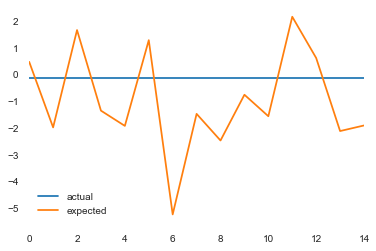

In [315]:
testing_result_df = pd.DataFrame({'actual':actual, 'expected':expected})
testing_result_df.plot()